<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/playground-dev/documentation/playground_mr0/mr0_RARE_2D_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pypulseq  &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

(RARE_2D_seq)=
# 2D RARE

Timing check passed successfully
Calculating repetition 66 / 66 - done


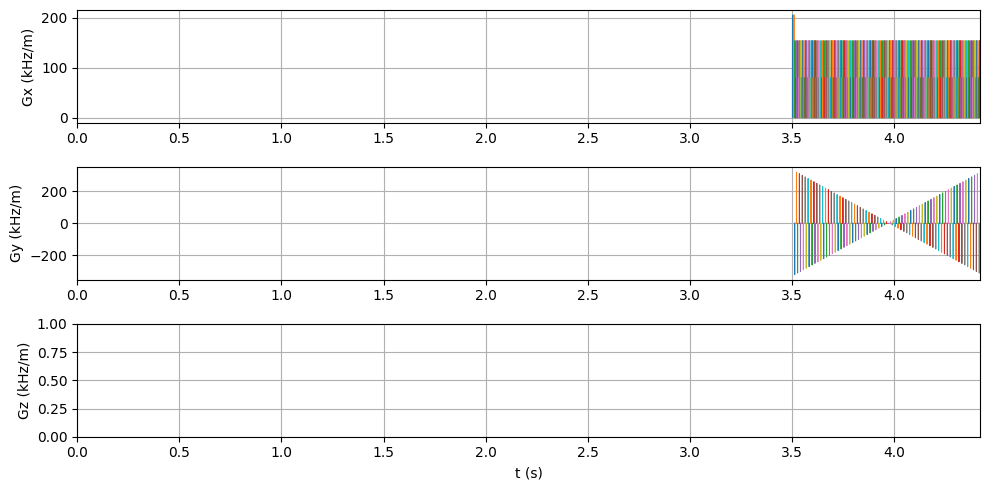

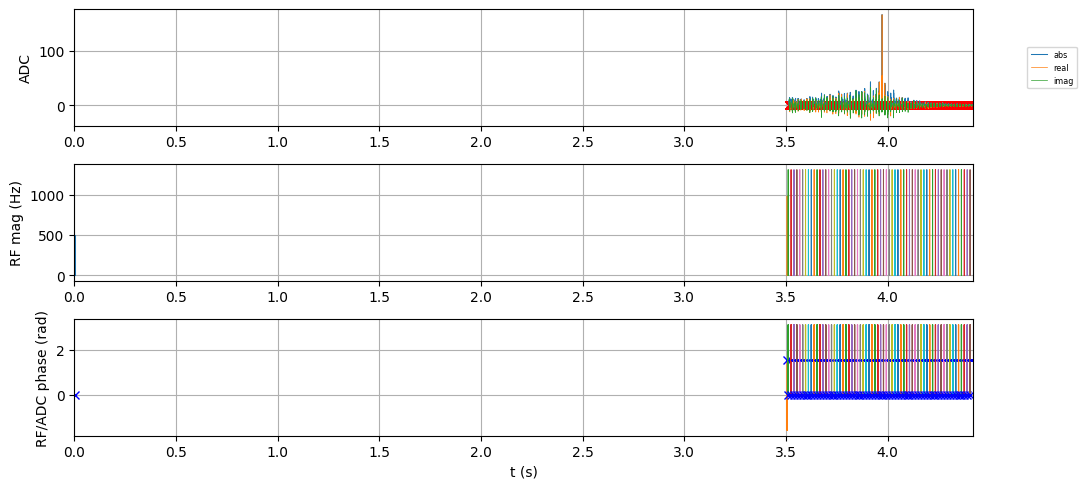

In [ ]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'exB02_SE_to_RARE_2D'

# %% S1. SETUP sys

# choose the scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=10e-6
)


# %% S2. DEFINE the sequence
seq = pp.Sequence()

# Define FOV and resolution
fov = 200e-3
slice_thickness = 8e-3

Nread = 64    # frequency encoding steps/samples
Nphase = 64    # phase encoding steps/samples

# Define rf events
rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=90 * np.pi / 180, phase_offset=90 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)
rf2, _, _ = pp.make_sinc_pulse(
    flip_angle=120 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)
# rf1 = pp.make_block_pulse(flip_angle=90 * np.pi / 180, duration=1e-3, system=system)
rf2.delay = 0

# Define timing according to system raster times
a = int(system.adc_raster_time * Nread * 10**7)
b = int(system.grad_raster_time * 10**7)
c = int(2e-3 * 10**7)
lcm_ab = abs(a * b) // math.gcd(a, b)
adc_raster_duration = (lcm_ab if round(c / lcm_ab) == 0 else round(c / lcm_ab) * lcm_ab) / 10**7

gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=adc_raster_duration, system=system)
adc = pp.make_adc(num_samples=Nread, duration=adc_raster_duration, phase_offset=90 * np.pi / 180, delay=gx.rise_time, system=system)
gx_pre0 = pp.make_trapezoid(channel='x', area=+(1.0 + 3.0) * gx.area / 2, duration=adc_raster_duration, system=system)
gx_prewinder = pp.make_trapezoid(channel='x', area=+3.0 * gx.area / 2, duration=adc_raster_duration, system=system)

# ======
# CONSTRUCT SEQUENCE
# ======
# seq.add_block(make_delay(5*sdel))

rf_prep = pp.make_block_pulse(flip_angle=180 * np.pi / 180, duration=1e-3, system=system)
# FLAIR
seq.add_block(rf_prep)
seq.add_block(pp.make_delay(3.5))
seq.add_block(gx_pre0)

seq.add_block(rf1)

pp.calc_duration(rf1)
pp.calc_duration(gx_pre0)

seq.add_block(gx_pre0, pp.make_delay(0.0041 - pp.calc_duration(rf1) - rf2.delay - rf2.t[-1] / 2 + rf2.ringdown_time / 2))

for ii in range(-Nphase // 2, Nphase // 2):  # e.g. -64:63
    seq.add_block(rf2)
    seq.add_block(pp.make_delay(0.0001))
    gp = pp.make_trapezoid(channel='y', area=ii / fov, duration=1e-3, system=system)
    gp_ = pp.make_trapezoid(channel='y', area=-ii / fov, duration=1e-3, system=system)
    seq.add_block(gx_prewinder, gp)
    seq.add_block(adc, gx)
    seq.add_block(gx_prewinder, gp_)
    seq.add_block(pp.make_delay(0.00008))


# %% S3. CHECK, PLOT and WRITE the sequence  as .seq
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]


#quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq,)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()


Reconstruction of the signal

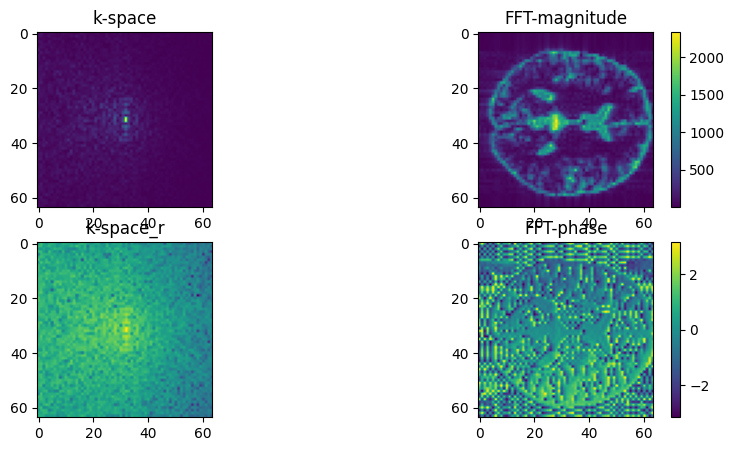

In [ ]:
# %% S6: MR IMAGE RECON of signal ::: #####################################

# fftshift
spectrum = torch.fft.fftshift(kspace)
# FFT
space = torch.fft.fft2(spectrum)
# fftshift
space = torch.fft.ifftshift(space)

fig = plt.figure()  # fig.clf()
plt.subplot(221)
plt.title('k-space')
plt.imshow(np.abs(kspace.numpy()))
plt.subplot(223)
plt.title('k-space_r')
plt.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(222)
plt.title('FFT-magnitude')
plt.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(224)
plt.title('FFT-phase')
plt.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()
